# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.251  train_ave_acc: 0.536  (4.45s - 884.84s remaining) ave_loss: 0.2510857331263355 ave_acc: 0.5361330918856698
EPOCH: 2.000  train_ave_loss: 0.241  train_ave_acc: 0.594  (8.32s - 823.83s remaining) ave_loss: 0.2411459291523153 ave_acc: 0.5938027922356225
EPOCH: 3.000  train_ave_loss: 0.237  train_ave_acc: 0.628  (11.64s - 764.58s remaining) ave_loss: 0.2365913006785678 ave_acc: 0.6284692588493093
EPOCH: 4.000  train_ave_loss: 0.232  train_ave_acc: 0.625  (14.99s - 734.35s remaining) ave_loss: 0.23224927590957833 ave_acc: 0.6247916337679857
EPOCH: 5.000  train_ave_loss: 0.230  train_ave_acc: 0.628  (18.30s - 713.86s remaining) ave_loss: 0.23042308647305734 ave_acc: 0.6283346594435015
EPOCH: 6.000  train_ave_loss: 0.226  train_ave_acc: 0.633  (21.62s - 699.02s remaining) ave_loss: 0.2259067823356591 ave_acc: 0.6332114346048149
EPOCH: 7.000  train_ave_loss: 0.221  train_ave_acc: 0.638  (24.88s - 686.00s remaining) ave_loss: 0.2205501324565442 ave_acc: 0.63

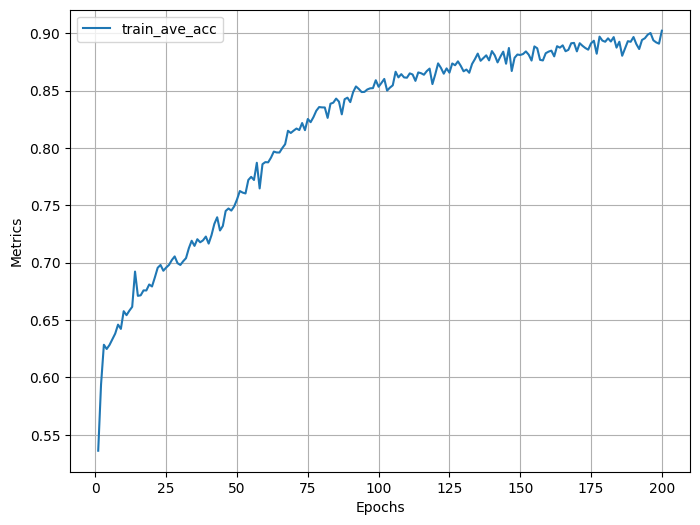

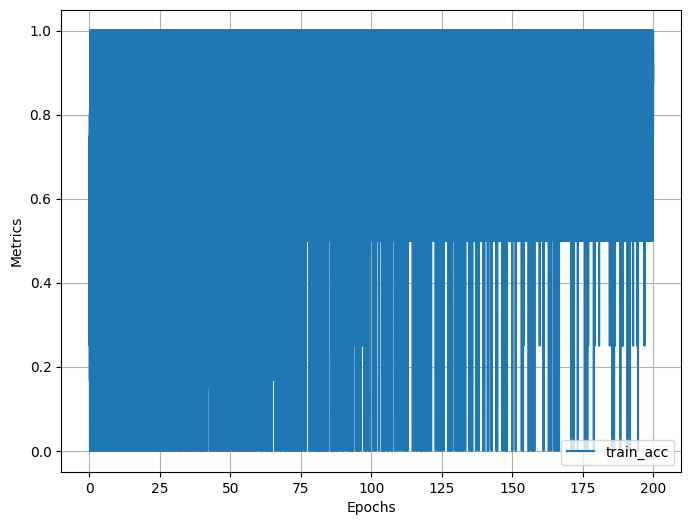

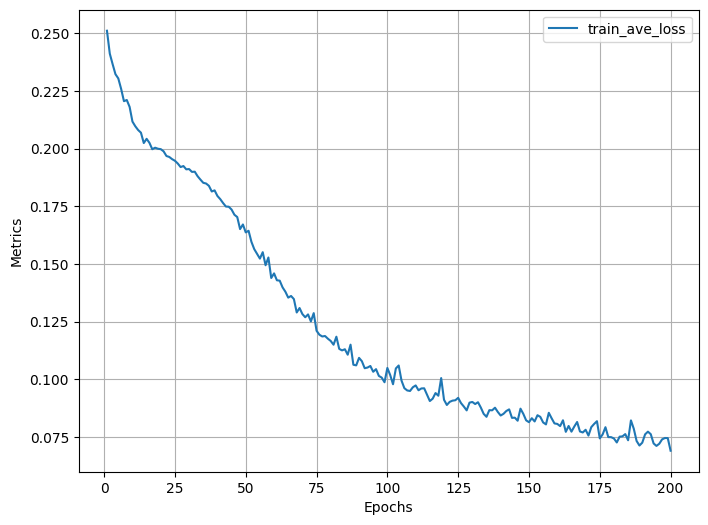

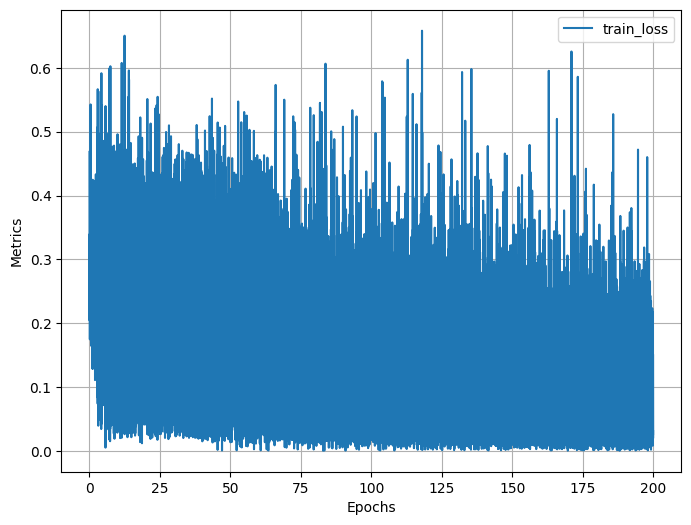

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5673316708229427
NN MC MSE: 0.3097679575568372
NN MC Seq Accuracy: 0.6184538653366584
NN MC Seq MSE: 0.2899267343841528


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.159  train_ave_acc: 0.500  (2.63s - 522.55s remaining) ave_loss: 0.1589192085765586 ave_acc: 0.4998808091550027
EPOCH: 2.000  train_ave_loss: 0.126  train_ave_acc: 0.530  (5.19s - 513.49s remaining) ave_loss: 0.1262375512255951 ave_acc: 0.5304650293251594
EPOCH: 3.000  train_ave_loss: 0.125  train_ave_acc: 0.528  (7.72s - 507.11s remaining) ave_loss: 0.1245442618809837 ave_acc: 0.5282463746458054
EPOCH: 4.000  train_ave_loss: 0.120  train_ave_acc: 0.557  (10.30s - 504.46s remaining) ave_loss: 0.12008601446742537 ave_acc: 0.557134663454471
EPOCH: 5.000  train_ave_loss: 0.119  train_ave_acc: 0.544  (12.85s - 501.08s remaining) ave_loss: 0.11868022488228037 ave_acc: 0.5436250148439193
EPOCH: 6.000  train_ave_loss: 0.118  train_ave_acc: 0.556  (15.40s - 497.88s remaining) ave_loss: 0.11757586009887831 ave_acc: 0.556342377783153
EPOCH: 7.000  train_ave_loss: 0.104  train_ave_acc: 0.580  (17.94s - 494.61s remaining) ave_loss: 0.10371388207924419 ave_acc: 0.579

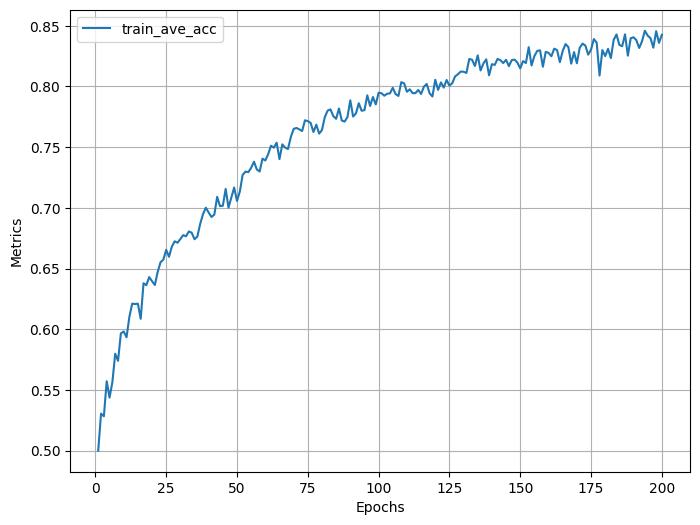

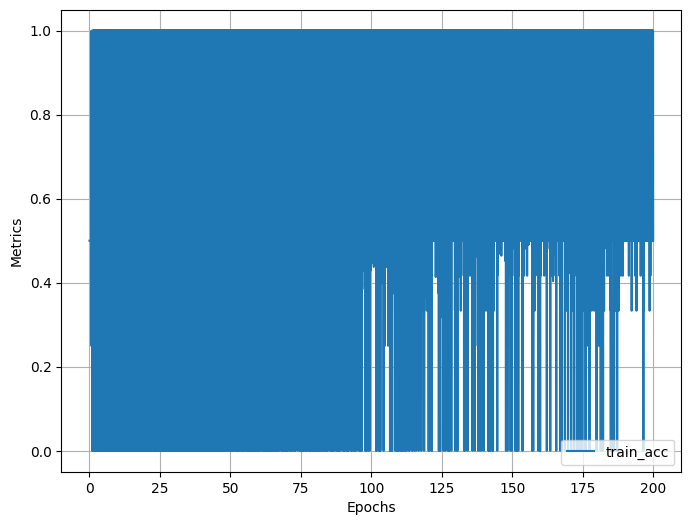

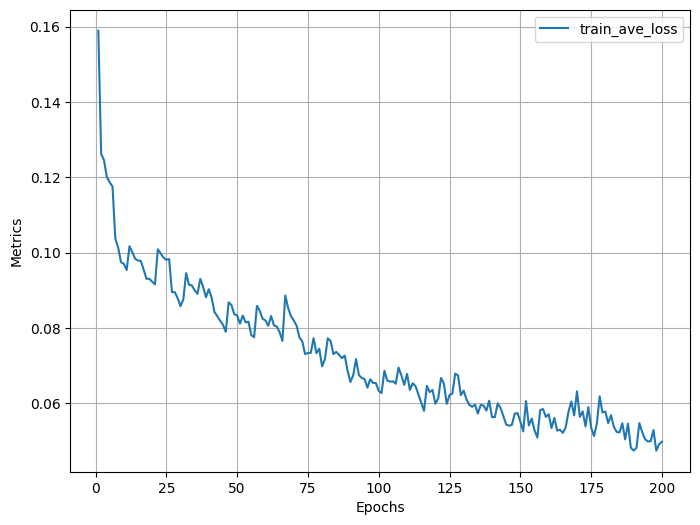

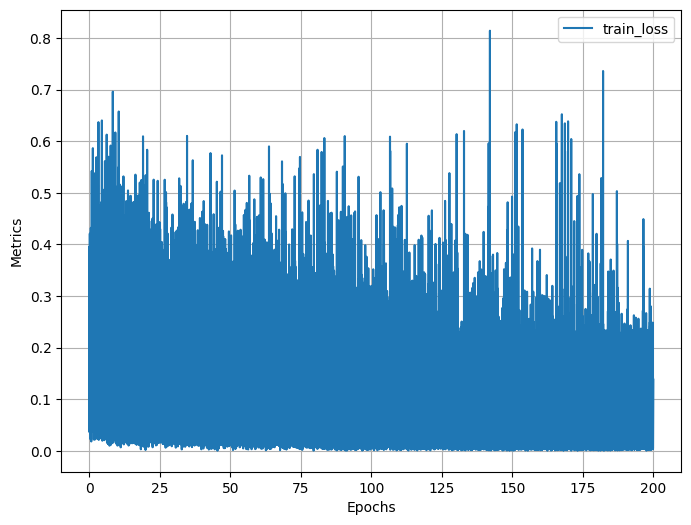

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5685785536159601
NN Sarsa MSE: 0.29843366117338505
NN Sarsa Seq Accuracy: 0.5910224438902744
NN Sarsa Seq MSE: 0.2671549903355853


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.064  train_ave_acc: 0.892  (2.54s - 505.68s remaining) ave_loss: 0.0637106268511009 ave_acc: 0.8923358710517908
EPOCH: 2.000  train_ave_loss: 0.055  train_ave_acc: 0.884  (5.03s - 497.69s remaining) ave_loss: 0.05468937032241538 ave_acc: 0.8836527702708604
EPOCH: 3.000  train_ave_loss: 0.051  train_ave_acc: 0.878  (7.47s - 490.46s remaining) ave_loss: 0.050715445908526634 ave_acc: 0.8784575246036034
EPOCH: 4.000  train_ave_loss: 0.050  train_ave_acc: 0.869  (9.93s - 486.67s remaining) ave_loss: 0.05021317017143811 ave_acc: 0.8688962468886756
EPOCH: 5.000  train_ave_loss: 0.045  train_ave_acc: 0.872  (12.41s - 484.10s remaining) ave_loss: 0.04545658344779808 ave_acc: 0.8724175331439534
EPOCH: 6.000  train_ave_loss: 0.046  train_ave_acc: 0.868  (14.85s - 480.09s remaining) ave_loss: 0.045591064767715385 ave_acc: 0.8683992904710186
EPOCH: 7.000  train_ave_loss: 0.056  train_ave_acc: 0.854

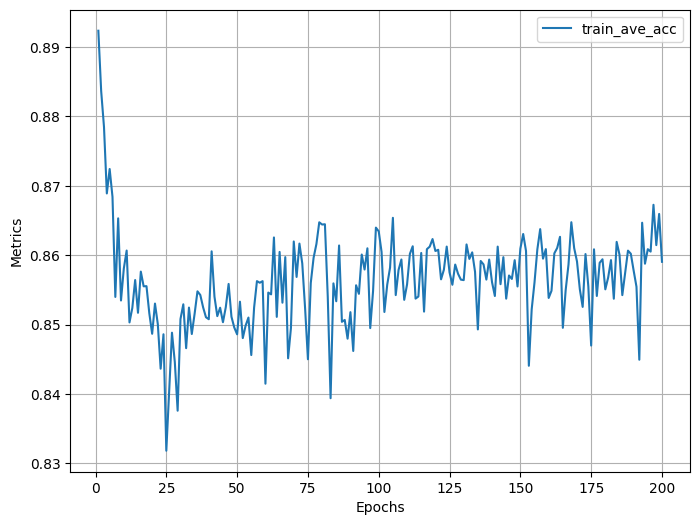

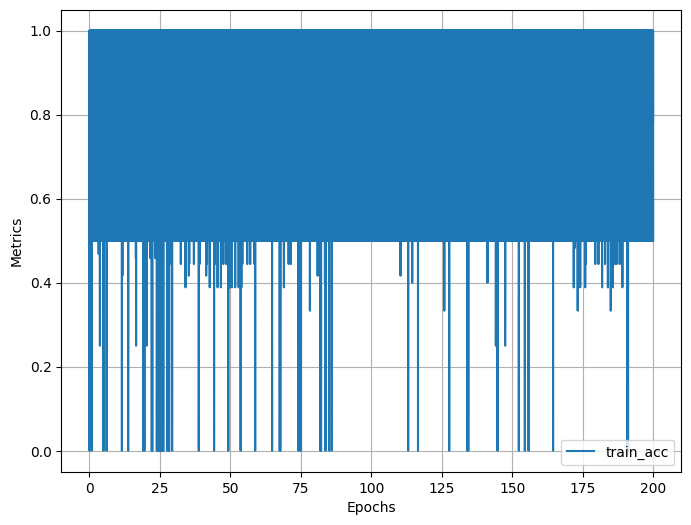

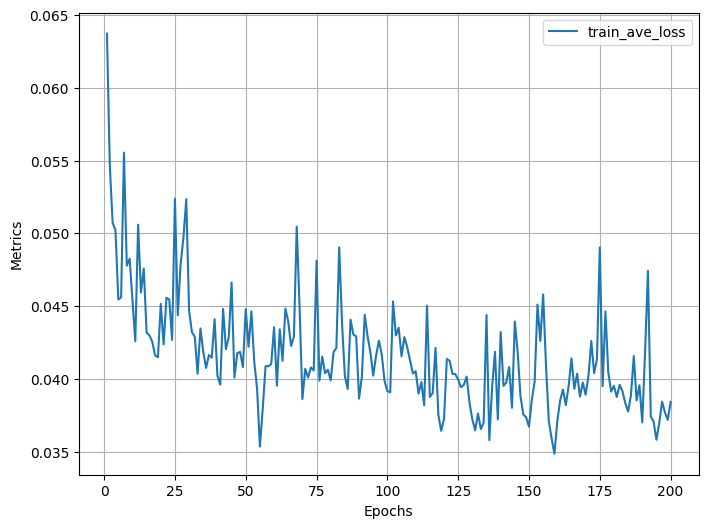

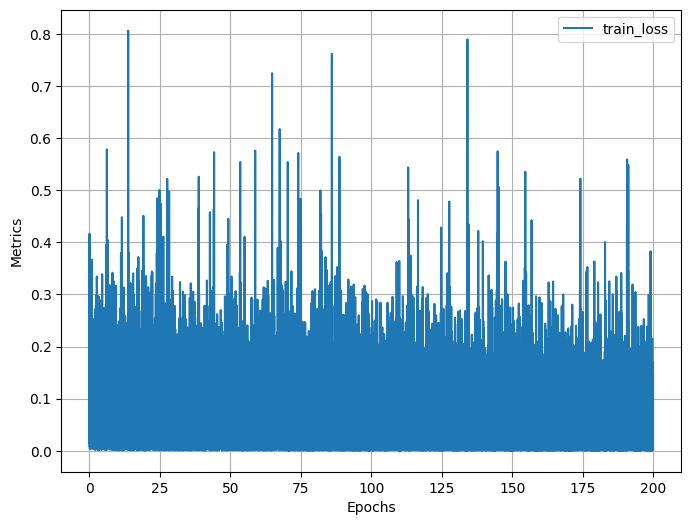

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5486284289276808
NN Sarsa With MC Init MSE: 0.2854008209340571
NN Sarsa With MC Init Seq Accuracy: 0.628428927680798
NN Sarsa With MC Init Seq MSE: 0.2702821166436727


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions